# Module 2 Final Project Specifications

<img src='Northwind_ERD.png'>



In [1]:
import sqlite3
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stat
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


## Four questions for hypothesis testing

1. **Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**
2. **Does the average revenue per order vary between customers from different regions?**
3. **Is the mean freight price significantly different between shipping companies?**
4. **Does supply region have a statistically significant effect on unit price?**

## Overview & Structure of analysis

#### a. Query required data via SQLite3 & perform the necessary join’s and integrating the data into a pandas dataframe
#### b. Scrub the data
#### c. Establish null and alternative hypothesis
#### d. Conduct statistical test(s) to determine significance & effect size.
#### e. Summarize findings 

<br>


## Question 1 

The data required to answer the research question, quantity of product ordered and discount amount, is located in the OrderDetail table. We will extract this data with SQL and store it in a dataframe.

### Connect to the database and import tables.


In [5]:
# create a connection to the database
conn = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_COLNAMES)
c = conn.cursor()
# query the database
c.execute("SELECT * FROM OrderDetail;")
# store results in a dataframe
orders = pd.DataFrame(c.fetchall())
orders.columns = [i[0] for i in c.description]
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [11]:
orders.tail()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00
2154,11077/77,11077,77,13.00,2,0.00


In [21]:
pd.DataFrame(orders.Discount.value_counts()).sort_index()

,Discount
0.00,1317
0.01,1
0.02,2
0.03,3
0.04,1
0.05,185
0.06,1
0.10,173
0.15,157
0.20,161


Based on an initial observation, discount rates (0.01, 0.02, 0.03, 0.04, 0.06) shows small sample size.

### Design experiment groups (Control VS Experiment)
####     - Control: customers who did not receive a discount
####     - Experimental: customers who received a discount

In [29]:
# create control and experimental groups
control = orders[orders['Discount'] == 0]
control = control['Quantity']


In [30]:
experiment = orders[orders['Discount'] != 0]
experiment = experiment['Quantity']

### Check for *Noramlity & Independene & Random* assumptions

#### - Normality check

C:\Users\jjsjk\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


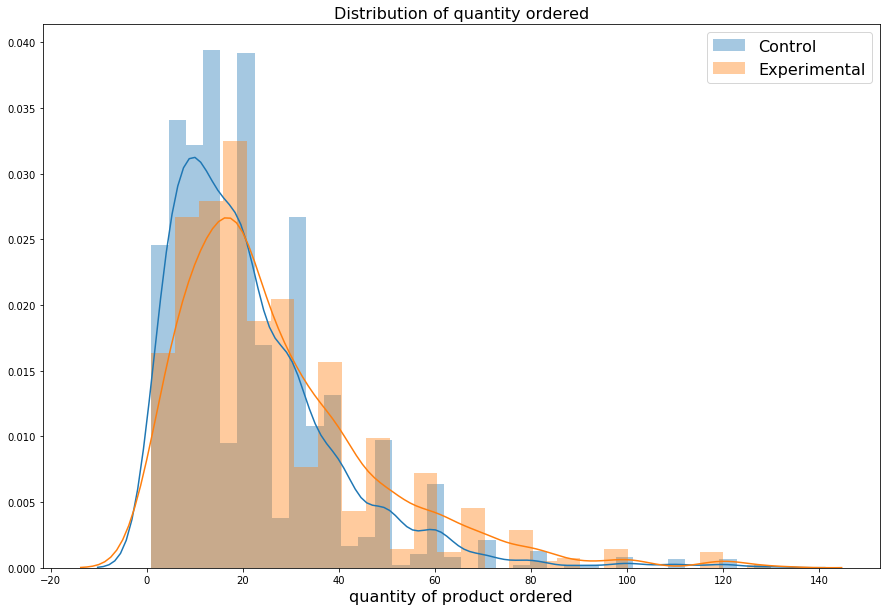

In [38]:
plt.figure(figsize=(15, 10))
sns.distplot(control, label='Control')
sns.distplot(exp, label='Experimental')
plt.title('Distribution of quantity ordered', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)
plt.legend(fontsize=16)

In [43]:
print( 'Distribution of Control:', stat.normaltest(control))
print('Distribution of experiment:', stat.normaltest(experiment))

Distribution of Control: NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Distribution of experiment: NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


Based on the observation, the given control and experiment groups seem to be skewed right. Interesting thing is the both groups distributions look very similar. We can see there is slight difference between the mean of contrl & experiment groups. experiment group mean is slightly shifted rightward. Further analysis is needed whether the difference is statistically significant or not.
<br>
normaltest shows that the p-values (2 tailed) are extremely small. It indicates that the given distributions are not normally distributed. 
<br>
Based on CLT for parameter estimaiton and hypothesis testing, we will create sampling distributions of sample means of both groups. 

#### - Independence & Randomness

It's obvious that the customers purchases are not dependet on each other. they make their own purchase independently. Furthermore, their purchases are made randomly.

<br>

### Create Sampling Distribution of Sample Mean

In [2]:
def create_sample(df, n):
    sample = []
    while len(sample) < n:
        x = np.random.choice(df) # making sure to pick randomly
        sample.append(x)
    return sample

def create_sampling_distribution(df, dist_size=1000, n=500):
    sampling_dist = [] 
    while len(sampling_dist) < dist_size:
        sample = create_sample(df, n)
        sample_mean = sum(sample)/len(sample)
        sampling_dist.append(sample_mean)
        
    return sampling_dist

In [49]:
control_sample = create_sampling_distribution(control)
experiment_sample = create_sampling_distribution(experiment)

Create an distribution plot with the new sampling distributions.

C:\Users\jjsjk\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


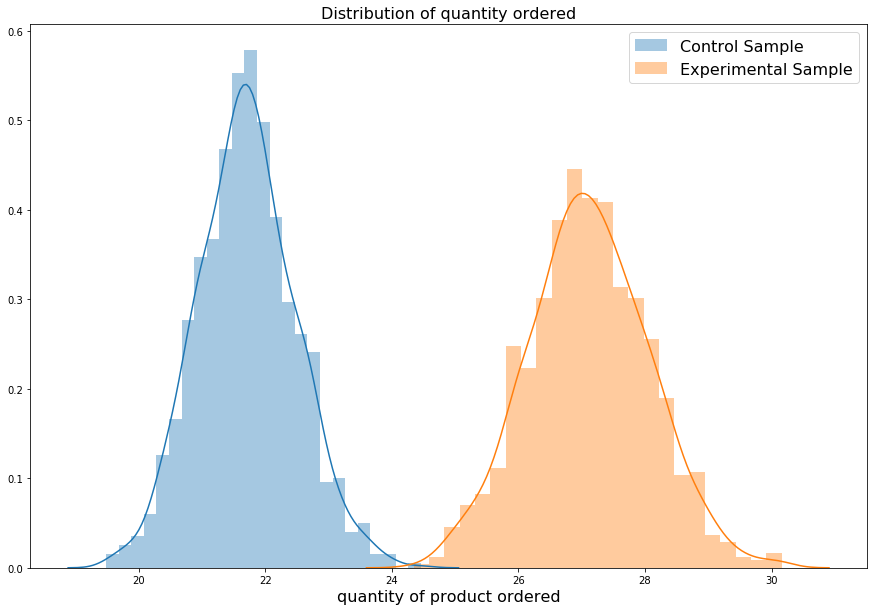

In [50]:
plt.figure(figsize=(15, 10))
sns.distplot(control_sample, label='Control Sample')
sns.distplot(experiment_sample, label='Experimental Sample')
plt.title('Distribution of quantity ordered', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)
plt.legend(fontsize=16)

In [59]:
pd.DataFrame(control_sample).mean()

0    21.706972
dtype: float64

Huge difference! the sampling distributions are normal and there is a clear difference in the means of two groups. the overlaop region is small too.

### Two sample t-test

#### Null Hypothesis VS Alternative Hypothesis

$H_o:$ mean quantity of product with discounts = mean quantity of product without discount




$H_a:$ mean quantity of product with discounts ≥ mean quantity of product without discount (21.7)


<br>


**Type I error**
- reject null hypotheses when it is True

**Business error interpretation**
- when there is no effect, a company keep offering discounts to the customers

<br>
                  
**type II error**
- fail to reject null hypotheses when it is false

**Business error interpretation**
- when there is effect on quatity of products sold, a company does  not offer any discounts) 


Before doing t-test, we need to check if the population and sample variances are equal

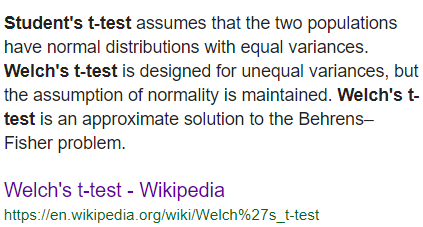

In [62]:
np.var(control) == np.var(experiment)
# Use Welch's t-test!

False

In [64]:
stat.ttest_ind(experiment_sample, control_sample, equal_var=False)


Ttest_indResult(statistic=139.9465976737774, pvalue=0.0)

ttest_ind returns a two_tailed p-value. In order to calculate p-value for right_tailed test, we need to divide by 2. <br>
We have 0 p-value. Hene, we found a strong evidence that the null hypothesis is not ture! In other words, the quantity of products sold with discounts is significantly higher than 21.7 ( mean of quantity sold without discounts).

### Effect size

Now, we know there is a significnat difference between the mean(s) of control and experiement groups. we need to calculate the magnitude of  of the difference(effect size).
<br>

Cohen's d where values of 0 ~ 0.2 have little or no effect and values of >= 0.8 have a large effect size. 

*-1.0: Perfect negative relationship.<br>
-0.7: Strong negative relationship<br>
-0.5: Moderate negative relationship<br>
-0.3: Weak negative relationship<br>
-0.0: No relationship.<br>
0.3: Weak positive relationship<br>
0.5: Moderate positive relationship<br>
0.7: Strong positive relationship<br>
1.0: Perfect positive relationship.<br>*

In [66]:
# function for calculating Cohen's d
def Cohen_d(group1, group2):

    diff = group1.mean()-group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1*var1+n2*var2) / (n1+n2)
  
    d = diff / np.sqrt(pooled_var)
    
    return d

# calculate Cohen's d for target and control samples
print("Cohen's d:" , Cohen_d(np.array(experiment_sample), np.array(control_sample)))

Cohen's d: 6.261733762357106


Our Cohen's d value is much higher than 0.8 so we interpret our results as having a large effect size, which supports the conclusion from the hypothesis test.

### ANOVA

Now the remaining question is at which discount level we observe a statisticaly significant impact on sales of products. 
In order to do this analysis, we will use ANOVA test to analyze differences among the different discount levels.

In [68]:
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [70]:
orders.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Dig into the bottom 4 discount rates **(0.03%, 0.02%, 0.01%, 0.04%, 0.06%)**

In [81]:
orders[orders.Discount == 0.06]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2149,11077/60,11077,60,34.0,2,0.06


In [82]:
orders[orders.Discount == 0.04]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2141,11077/20,11077,20,81.0,1,0.04


In [83]:
orders[orders.Discount == 0.03]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2139,11077/14,11077,14,23.25,1,0.03
2140,11077/16,11077,16,17.45,2,0.03
2150,11077/64,11077,64,33.25,2,0.03


In [84]:
orders[orders.Discount == 0.02]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2133,11077/6,11077,6,25.0,1,0.02
2146,11077/46,11077,46,12.0,3,0.02


In [87]:
orders['Quantity'].groupby(orders['Discount']).sum()

Discount
0.00    28599
0.01        2
0.02        4
0.03        5
0.04        1
0.05     5182
0.06        2
0.10     4366
0.15     4456
0.20     4351
0.25     4349
Name: Quantity, dtype: int64

The above numbers show the number of items sold for each discount rate ( not the number of order).
There are 10 different discount rates. At 0.04% discount rate there was only 1 item sold.

Perform ANOVA analysis (one way) among different discount groups

In [90]:
anova_result_ols = ols('Quantity~C(Discount)', data = orders).fit()

In [92]:
anova_result_table = sm.stats.anova_lm(anova_result_ols, typ=2)

In [93]:
anova_result_table

,sum_sq,df,F,PR(>F)
C(Discount),21258.403604,10.0,6.011811,4.704231e-09
Residual,758141.232591,2144.0,NaN,NaN


The P-value = 4.704231e-09 shows that there is a significant difference among different discount groups. In order to further analyze which discount rate has statistically significant differences in sales, we need to perform comparison analysis with all possible pairwise means using Tukey's HSD test.

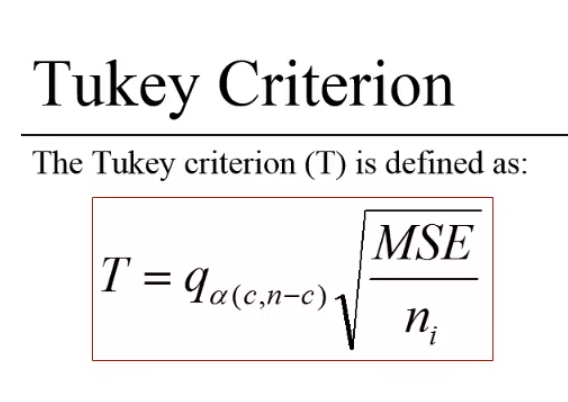

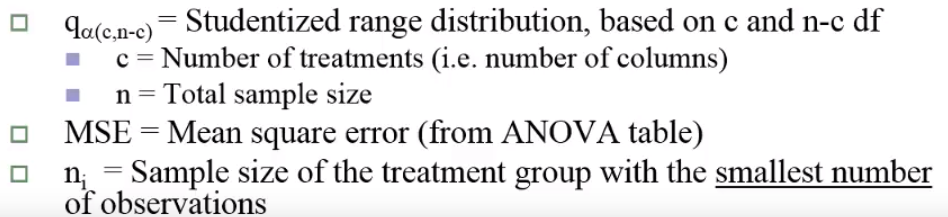

In [94]:
mc = MultiComparison(orders['Quantity'], orders['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

What we need to pay attention here is the pair comparison containing no discount rate. We want to know if those discounts rates really produce meaningful differences in sales of products compare to not giving out discounts.<br>

**According to the result above, we reject null hypothesis ( $M_1 = M_2$) at 2%, 5%, 15%, 25%. That means, when discount rates are at  2%, 5%, 15%, 25%, we observe a statistically significant effect on the quantity of product sold.**

<br>

## Question 2

### Null Hypothesis VS Alternative Hypothesis

$H_o:$ average amount spent for each order is the same among different customer regions


$H_a:$ average amount spent for each order is different among different customer regions (both tailed)


### Connect to the database and import tables. 


In [205]:
c.execute("SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount\
 FROM Customer c\
 INNER JOIN [Order] o ON c.Id = o.CustomerId\
 INNER JOIN OrderDetail od ON od.OrderId = o.Id")


In [206]:
sales_customer_region = pd.DataFrame(c.fetchall())


In [207]:
sales_customer_region.head() # name the columns

,0,1,2,3,4
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [208]:
sales_customer_region.columns = [i[0] for i in c.description]

In [209]:
sales_customer_region.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [210]:
sales_customer_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 5 columns):
Region       2078 non-null object
OrderId      2078 non-null int64
Quantity     2078 non-null int64
UnitPrice    2078 non-null float64
Discount     2078 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 81.2+ KB


Change data types to *UnitPrice, Discount* **int64**

In [211]:
sales_customer_region.UnitPrice =  sales_customer_region.UnitPrice.astype('int64')
sales_customer_region.Discount = sales_customer_region.Discount.astype('int64') 

In [212]:
sales_customer_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 5 columns):
Region       2078 non-null object
OrderId      2078 non-null int64
Quantity     2078 non-null int64
UnitPrice    2078 non-null int64
Discount     2078 non-null int64
dtypes: int64(4), object(1)
memory usage: 81.2+ KB


In [213]:
sales_customer_region['price_per_order']  = sales_customer_region.Quantity * sales_customer_region.UnitPrice\
* (1-sales_customer_region.Discount)

Now the new column *'price_per_order' is created reflecting the revenu per order.

In [214]:
# Dropping the columns for quantity, unit price and discount
sales_customer_region.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

In [215]:
sales_customer_region = sales_customer_region.groupby(['Region', 'OrderId'])['price_per_order'].sum()

In [216]:
sales_customer_region = pd.DataFrame(sales_customer_region)

In [220]:
sales_customer_region.reset_index(level=0, inplace=True)
# run twice to convert a index to columns

In [221]:
sales_customer_region

,OrderId,Region,price_per_order
0,10289,British Isles,474
1,10298,British Isles,3105
2,10309,British Isles,1733
3,10315,British Isles,514
4,10318,British Isles,224
5,10321,British Isles,140
6,10335,British Isles,2521
7,10355,British Isles,450
8,10359,British Isles,3588
9,10364,British Isles,925


In [222]:
# Drop OrderId column 
sales_customer_region.drop('OrderId', axis=1, inplace=True)

In [223]:
sales_customer_region

,Region,price_per_order
0,British Isles,474
1,British Isles,3105
2,British Isles,1733
3,British Isles,514
4,British Isles,224
5,British Isles,140
6,British Isles,2521
7,British Isles,450
8,British Isles,3588
9,British Isles,925


In [224]:
sales_customer_region['Region'].value_counts()

Western Europe     272
North America      152
South America      127
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     21
Eastern Europe       7
Name: Region, dtype: int64

In [137]:
sales_customer_region.groupby('Region').count()
#observe that 'Region' is now index column

,OrderId,Quantity,UnitPrice,Discount,price_per_order
Region,,,,,
British Isles,190,190,190,190,190
Central America,55,55,55,55,55
Eastern Europe,16,16,16,16,16
North America,427,427,427,427,427
Northern Europe,143,143,143,143,143
Scandinavia,70,70,70,70,70
South America,304,304,304,304,304
Southern Europe,137,137,137,137,137
Western Europe,736,736,736,736,736


In [138]:
sales_customer_region.groupby('Region').count()['price_per_order']

Region
British Isles      190
Central America     55
Eastern Europe      16
North America      427
Northern Europe    143
Scandinavia         70
South America      304
Southern Europe    137
Western Europe     736
Name: price_per_order, dtype: int64

Before using ANOVA test, we need to first consider the assumption of ANOVA. Different groups(regions) are supposed to have equal variances (homogeneity of variance)


ANOVA has three assumptions:

1) homoscedasticity of dependent variable (equality of variances among group)

2) dependent variable is normally distributed within each group

3) each observation in the sample is independent from all other.

ANOVA generally requries more than 20 subjects in the sample. Therefore, we need to combine some of the groups(region) with less than 20 sample size, as long as they  make sense geographically.

In [227]:
sales_customer_region.loc[(sales_customer_region.Region == 'Eastern Europe') | (sales_customer_region.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'
sales_customer_region.loc[(sales_customer_region.Region == 'Scandinavia') | (sales_customer_region.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'
sales_customer_region.loc[(sales_customer_region.Region == 'Central America') | (sales_customer_region.Region == 'South America'),'Region'] = 'South and Central America'

Eastern Europe + Southern Europe<br>
Scandinavia + Northern Europe<br>
Central + South America<br>

In [258]:
sales_customer_region.groupby(['Region'])['Region'].count() 
# count of orders by Region

Region
British Isles                       75
North America                      152
Northern Europe and Scandinavia     83
South and Central America          148
Southern and Eastern Europe         71
Western Europe                     272
Name: Region, dtype: int64

In [254]:
sales_customer_region.groupby(['Region'])['price_per_order'].sum()
# total revenue by Region

Region
British Isles                      116770
North America                      315731
Northern Europe and Scandinavia    118508
South and Central America          164936
Southern and Eastern Europe         51440
Western Europe                     530511
Name: price_per_order, dtype: int64

In [255]:
sales_customer_region.groupby(['Region'])['price_per_order'].mean()
# Average revenue per order by Region

Region
British Isles                      1556.933333
North America                      2077.177632
Northern Europe and Scandinavia    1427.807229
South and Central America          1114.432432
Southern and Eastern Europe         724.507042
Western Europe                     1950.408088
Name: price_per_order, dtype: float64

Going back to the questions we need to answer: is there a significant difference in the average amount $ spent on each order among different regions. because ANOVA assumes the data is normally distributed and the sample gorups, in this case different regions, have similiar variance. 

In [259]:
sales_customer_region

,Region,price_per_order
0,British Isles,474
1,British Isles,3105
2,British Isles,1733
3,British Isles,514
4,British Isles,224
5,British Isles,140
6,British Isles,2521
7,British Isles,450
8,British Isles,3588
9,British Isles,925


In [261]:
lm = ols('price_per_order ~ C(Region)', sales_customer_region).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),1.595919e+08,5.0,8.590414,6.141338e-08
Residual,2.953888e+09,795.0,NaN,NaN


The ANOVA table above shows that the P-value is lower than the alpha value 0.05. Therefore, we can reject the null hypothesis and accept the alternative pypothesis. In other words, depending on the region, there is a statistical difference in average order value. 

## Question 3


For the question 3, we want to know if there is a significant difference in freight shipping price (average) depending on the different shipping companies. In order to answer the question, we need information about CompnayName, Freight($),  from Shipper and Order table

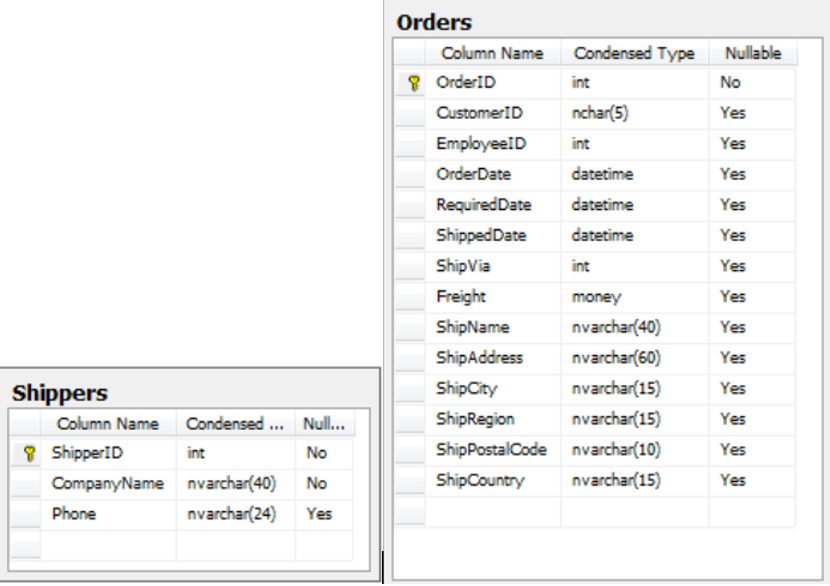

Let's take a look at the two tables we need.  What are *ShipName* / *Freight (money)?*

In [264]:
# Shipper table
c.execute('''
SELECT *
FROM Shipper
''')
df_shipper = pd.DataFrame(c.fetchall())
df_shipper.columns = [i[0] for i in c.description]
freight.head()

,CompanyName,Freight,Id
0,Federal Shipping,32.38,10248
1,Speedy Express,11.61,10249
2,United Package,65.83,10250
3,Speedy Express,41.34,10251
4,United Package,51.30,10252


In [266]:
#Order table
c.execute('''
SELECT *
FROM [Order]
''')
df_order = pd.DataFrame(c.fetchall())
df_order.columns = [i[0] for i in c.description]
freight.head()

,CompanyName,Freight,Id
0,Federal Shipping,32.38,10248
1,Speedy Express,11.61,10249
2,United Package,65.83,10250
3,Speedy Express,41.34,10251
4,United Package,51.30,10252


In [262]:
c.execute('''SELECT CompanyName, Freight, "Order".ID
             FROM Shipper
             JOIN "Order"
             ON Shipper.ID = ShipVia;''')

freight = pd.DataFrame(c.fetchall())
freight.columns = [i[0] for i in c.description]
freight.head()

,CompanyName,Freight,Id
0,Federal Shipping,32.38,10248
1,Speedy Express,11.61,10249
2,United Package,65.83,10250
3,Speedy Express,41.34,10251
4,United Package,51.30,10252


In [270]:
freight.CompanyName.value_counts()

United Package      326
Federal Shipping    255
Speedy Express      249
Name: CompanyName, dtype: int64

It appears that *Freight* is the price the company pays to the shipping companies. Also, there are three different shipping companies; United Package, Federal Shipping, and Sppedy Express.

$H_o$: There is no difference in the mean price paid to the shipping companies<br>

$H_a$: There is statistical difference in the mean of price paid to the shipping companies 

In [271]:
results = ols( 'Freight~C(CompanyName)', data = freight).fit()
aov_table = sm.stats.anova_lm(results, type=2)
print(aov_table)

                   df        sum_sq       mean_sq        F    PR(>F)
C(CompanyName)    2.0  6.788200e+04  33941.001137  2.49781  0.082885
Residual        827.0  1.123753e+07  13588.301613      NaN       NaN


C:\Users\jjsjk\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


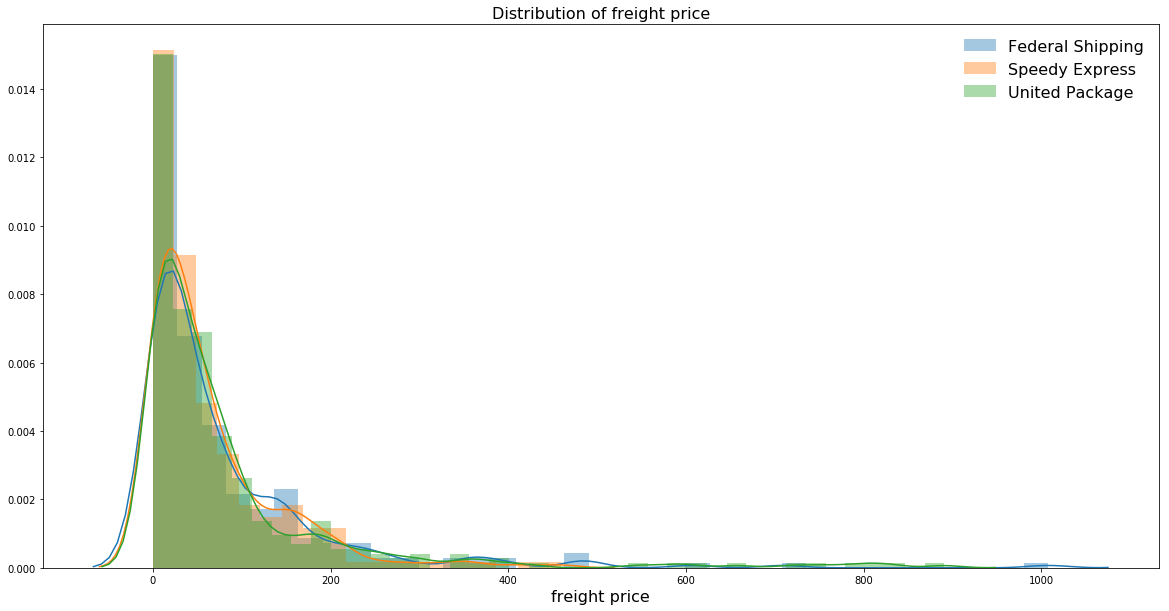

In [273]:
plt.figure(figsize=(20, 10))
sns.distplot(freight[freight['CompanyName'] == 'Federal Shipping']['Freight'], label='Federal Shipping')
sns.distplot(freight[freight['CompanyName'] == 'Speedy Express']['Freight'], label='Speedy Express')
sns.distplot(freight[freight['CompanyName'] == 'United Package']['Freight'], label='United Package')

plt.title('Distribution of freight price', fontsize=16)
plt.xlabel('freight price', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

Distributions are very right-skewed. We will create sampling distributions to normalize the distributions and apply ANOVA analysis.

In [ ]:
fedship = freight[freight['CompanyName'] == 'Federal Shipping']['Freight']
speedyship = freight[freight['CompanyName'] == 'Speedy Express']['Freight']
unitedship = freight[freight['CompanyName'] == 'United Package']['Freight']

In [276]:
# create sampling distribution of sample mean, use sample size of 200
f_ship = create_sampling_distribution(fedship, n=200)
s_ship = create_sampling_distribution(speedyship, n=200)
u_ship = create_sampling_distribution(unitedship, n=200)

C:\Users\jjsjk\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


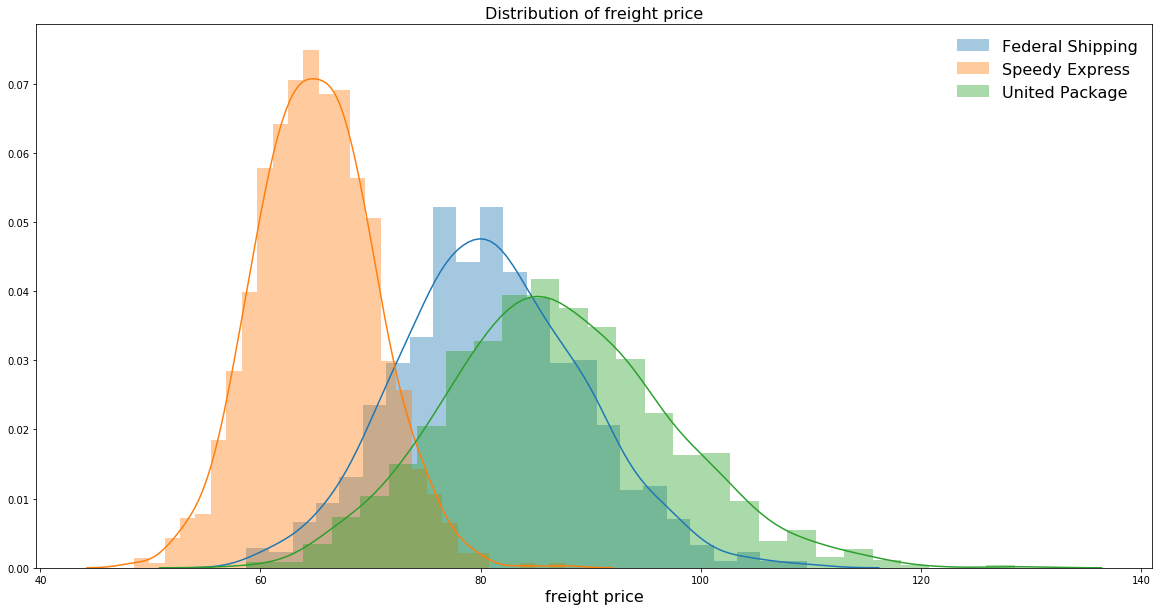

In [277]:
plt.figure(figsize=(20, 10))
sns.distplot(f_ship, label='Federal Shipping')
sns.distplot(s_ship, label='Speedy Express')
sns.distplot(u_ship, label='United Package')

plt.title('Distribution of freight price', fontsize=16)
plt.xlabel('freight price', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

In [288]:
f_ship = pd.DataFrame(f_ship)
s_ship = pd.DataFrame(s_ship)
u_ship = pd.DataFrame(u_ship)

In [289]:
f_ship['CompanyName'] ='Federal Shipping'
s_ship['CompanyName'] = 'Speedy Express'
u_ship['CompanyName'] ='United Package'

In [299]:

ship_sampling = f_ship.append([s_ship,u_ship])

In [311]:
ship_sampling.columns = ['freight', 'CompanyName']

In [313]:
results = ols( 'freight ~ C(CompanyName)', data = ship_sampling).fit()
aov_table = sm.stats.anova_lm(results, type=2)
print(aov_table)

                    df         sum_sq        mean_sq            F  PR(>F)
C(CompanyName)     2.0  258884.460360  129442.230180  1934.796041     0.0
Residual        2997.0  200506.076975      66.902261          NaN     NaN


**It appears that P-value is approximately 0, meaning we can reject the null hypothesis and there are significant differences in average shipping money between different companies.**

### Question 4

For question 4, we want to know if supplier regions make any statistical differences on unit price. In order to do analysis, we need two tables: Supplier and Product.<br>
<br>
$H_o$: There is no difference in the mean unit price among regions<br>
$H_a$: There is differecne in the mean unit price among regions
<br>

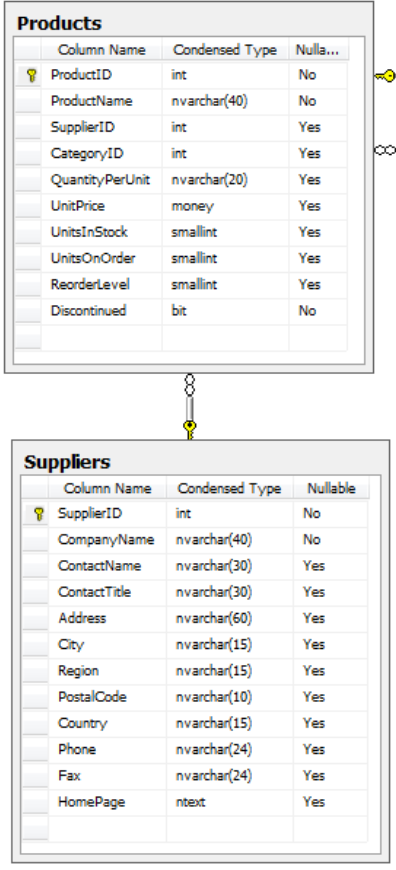

In [6]:
c.execute('''SELECT Region, UnitPrice
             FROM Supplier
             JOIN Product
             ON SupplierID;''')

supply = pd.DataFrame(c.fetchall())
supply.columns = [i[0] for i in c.description]
supply['Region'].value_counts()

North America      462
Western Europe     462
Northern Europe    308
Southern Europe    231
Eastern Asia       154
Scandinavia        154
British Isles      154
NSW                 77
South-East Asia     77
Victoria            77
South America       77
Name: Region, dtype: int64

In [7]:
supply['Region'].unique()

array(['British Isles', 'North America', 'Eastern Asia',
       'Southern Europe', 'Victoria', 'Northern Europe', 'South America',
       'Western Europe', 'Scandinavia', 'South-East Asia', 'NSW'],
      dtype=object)

C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:

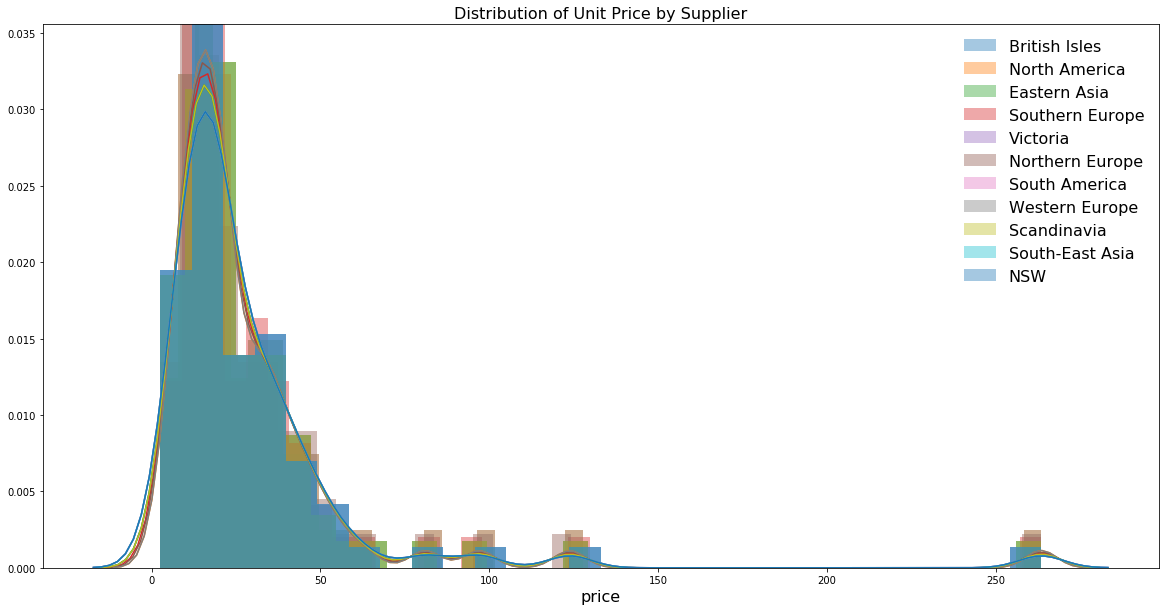

In [8]:
plt.figure(figsize=(20, 10))
for a in supply['Region'].unique():
    sns.distplot(supply['UnitPrice'][supply['Region'] == a], label = a)
plt.title('Distribution of Unit Price by Supplier', fontsize=16)
plt.xlabel('price', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

Let's create sampling distributions for each groups to normalize the data and see if there is a visual difference between groups. 


In [27]:
def create_sample1(df, n):
    sample = []
    while len(sample) < n:
        x = np.random.choice(df) # making sure to pick randomly
        sample.append(x)
    return sample

def create_sampling_distribution1(df, dist_size=500, n=50):
    sampling_dist = [] 
    while len(sampling_dist) < dist_size:
        sample = create_sample1(df, n)
        sample_mean = sum(sample)/len(sample)
        sampling_dist.append(sample_mean)
        
    return sampling_dist

In [28]:
British_Isles_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'British Isles'])
North_America_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'North America'])
Eastern_Asia_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'Eastern Asia'])
Southern_Europe_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'Southern Europe'])
Victoria_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'Victoria'])
Northern_Europe_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'Northern Europe'])
South_America_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'South America'])
Western_Europe_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'Western Europe'])
Scandinavia_sample = create_sampling_distribution(supply.UnitPrice[supply['Region'] == 'Scandinavia'])


C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jjsjk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:

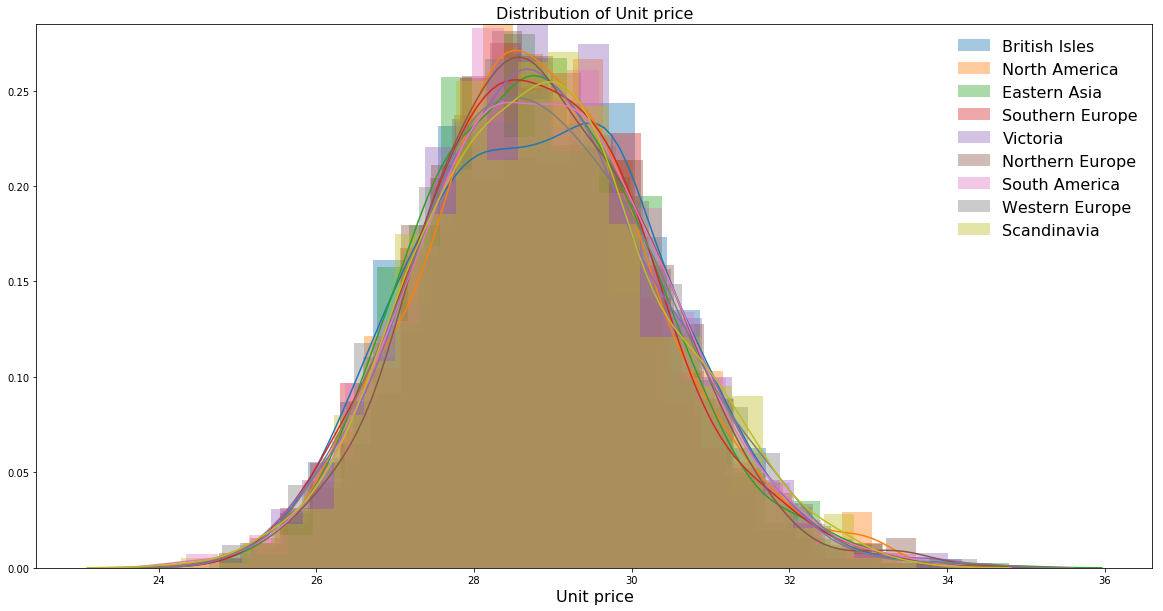

In [31]:
plt.figure(figsize=(20, 10))
sns.distplot(British_Isles_sample, label='British Isles')
sns.distplot(North_America_sample, label='North America')
sns.distplot(Eastern_Asia_sample, label='Eastern Asia')
sns.distplot(Southern_Europe_sample, label='Southern Europe')
sns.distplot(Victoria_sample, label='Victoria')
sns.distplot(Northern_Europe_sample, label='Northern Europe')
sns.distplot(South_America_sample, label='South America')
sns.distplot(Western_Europe_sample, label='Western Europe')
sns.distplot(Scandinavia_sample, label='Scandinavia')

plt.title('Distribution of Unit price', fontsize=16)
plt.xlabel('Unit price', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

 Just by looking at the distribution of all the different regions of suppliers. They seem almost identical. It appears that the null hypothesis seems to be true. Let's test out with ANOVA analysis.|

Even after the sampling distribution, visually we can suspect that there is almost no difference in mean of different groups. Further ANOVA needed.

In [32]:
results = ols('UnitPrice ~ C(Region)', data=supply).fit()
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                 sum_sq      df             F  PR(>F)
C(Region)  1.447654e-25    10.0  1.276367e-29     1.0
Residual   2.520190e+06  2222.0           NaN     NaN


As we expected, the p-value for the distributions is 1. This indicates that there is no significant difference between regions of suppliers. As a result, we accept the null hypothesis and reject alternative hypothesis. 